<a href="https://colab.research.google.com/github/manujism/1F_Drawing_Simulations/blob/main/Client_Specific_agressive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Successfully loaded 'Monthly Returns Aug15-Jul25.xlsx' ---

--- Select Assets for Optimization ---
Available assets:
  [1] Large Cap Index
  [2] Flexi Cap
  [3] Mid Cap
  [4] Small Cap
  [5] Sectoral
  [6] Aggressive Hybrid
  [7] Gold
  [8] Bitcoin
  [9] Debt

Enter the numbers for the assets you want to consider, separated by commas: 9,2,4
-> The following assets will be used for optimization: Flexi Cap, Small Cap, Debt
--- Successfully loaded 'Client Data.xlsx' ---
-> Investment horizon set to 344 months based on client data.

--- Client Financial Profile ---
Enter the client's current corpus (initial investment): 11361117

Select Client Risk Tolerance:
  [1] Conservative (Prioritizes capital preservation and liquidity)
  [2] Moderate (Balanced approach to risk and return)
  [3] Aggressive (Prioritizes high absolute and risk-adjusted returns)
Enter your choice (1, 2, or 3): 3
-> Risk Profile set to: Aggressive
Enter the number of random portfolios to test (e.g., 500): 50
Enter si

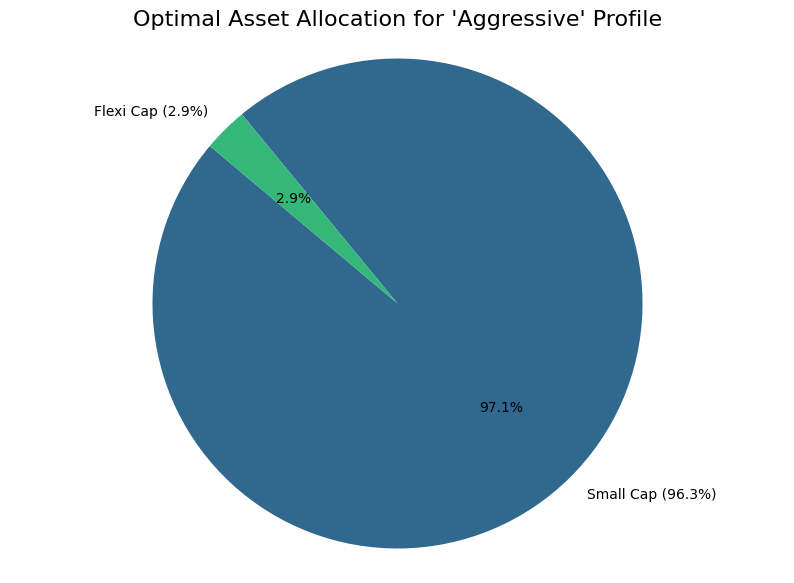

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import random


RISK_FREE_RATE_ANNUAL = 0.064

# --- Portfolio Generation and Analysis Functions ---
def analyze_portfolio_metrics(weights, assets, monthly_returns_df):
    """Calculates key theoretical metrics for a given portfolio without printing them."""
    if not weights or not assets:
        return 0, 0, 0, 0

    portfolio_returns = monthly_returns_df[assets].dot(pd.Series(weights))
    mean_monthly_return = portfolio_returns.mean()
    std_dev_monthly = portfolio_returns.std()
    risk_free_rate_monthly = (1 + RISK_FREE_RATE_ANNUAL)**(1/12) - 1

    # Calculate Annualized Return and Volatility
    annualized_mean_return = ((1 + mean_monthly_return) ** 12) - 1
    annualized_volatility = std_dev_monthly * np.sqrt(12)

    # Calculate Sharpe Ratio
    if std_dev_monthly > 0:
        sharpe_ratio = (mean_monthly_return - risk_free_rate_monthly) / std_dev_monthly
        annualized_sharpe_ratio = sharpe_ratio * np.sqrt(12)
    else:
        annualized_sharpe_ratio = np.inf

    # --- NEW: Calculate Sortino Ratio (for downside risk) ---
    negative_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = negative_returns.std()
    if downside_deviation > 0:
        sortino_ratio = (mean_monthly_return - risk_free_rate_monthly) / downside_deviation
        annualized_sortino_ratio = sortino_ratio * np.sqrt(12)
    else:
        # If no downside deviation, Sortino is effectively infinite (very good)
        annualized_sortino_ratio = np.inf

    return annualized_mean_return, annualized_volatility, annualized_sharpe_ratio, annualized_sortino_ratio

def generate_random_portfolio(assets, risk_profile):
    """
    Generates a single, random asset allocation that adheres to the defined risk profile constraints.
    """
    weights = {}

    # Define asset categories
    high_risk_assets = ['Mid Cap', 'Small Cap', 'Sectoral', 'Bitcoin']
    medium_risk_assets = ['Large Cap Index', 'Flexi Cap', 'Aggressive Hybrid']
    low_risk_assets = ['Gold', 'Debt']

    # Get the subset of available assets that fall into each risk category
    available_high_risk = [asset for asset in assets if asset in high_risk_assets]
    available_medium_risk = [asset for asset in assets if asset in medium_risk_assets]
    available_low_risk = [asset for asset in assets if asset in low_risk_assets]

    while True: # Loop until a valid portfolio is generated
        raw_weights = np.random.dirichlet(np.ones(len(assets)), size=1)[0]
        temp_weights = {asset: weight for asset, weight in zip(assets, raw_weights)}

        # Calculate total allocation to each risk category
        high_risk_alloc = sum(temp_weights.get(asset, 0) for asset in available_high_risk)
        low_risk_alloc = sum(temp_weights.get(asset, 0) for asset in available_low_risk)

        # Check if the allocation meets the risk profile constraints
        if risk_profile == 'Conservative' and (high_risk_alloc > 0.30 or low_risk_alloc < 0.40):
            continue
        if risk_profile == 'Moderate' and (high_risk_alloc > 0.60 or low_risk_alloc < 0.15):
            continue
        if risk_profile == 'Aggressive' and high_risk_alloc < 0.40:
            continue

        weights = temp_weights
        break

    return weights

# --- Function to run all simulations for a single portfolio ---
def run_simulation_for_portfolio(weights, initial_investment, sip_schedule, withdrawal_schedule, returns_df, num_simulations):
    """
    Runs the full Monte Carlo simulation for a single portfolio and returns key performance indicators.
    """
    final_corpus_values = []
    liquidity_failures = 0
    investment_horizon = len(sip_schedule)

    for _ in range(num_simulations):
        corpus_value = initial_investment
        sip_value = 0
        liquidity_failed = False

        for month_index in range(investment_horizon):
            # Apply withdrawal first to check for liquidity
            corpus_value -= withdrawal_schedule[month_index]

            # --- Liquidity Check ---
            if corpus_value < 0:
                liquidity_failed = True
                break # Stop this simulation run as it has failed

            sip_value += sip_schedule[month_index]

            random_month_returns = returns_df.sample(1).iloc[0]
            portfolio_return = sum(weights.get(asset, 0) * random_month_returns.get(asset, 0) for asset in weights)

            corpus_value *= (1 + portfolio_return)
            sip_value *= (1 + portfolio_return)

        if liquidity_failed:
            liquidity_failures += 1
            # A failed portfolio results in a zero final value for penalization
            final_corpus_values.append(0)
        else:
            final_corpus_values.append(corpus_value + sip_value)

    # Calculate results
    liquidity_sufficiency = 1 - (liquidity_failures / num_simulations)
    median_corpus = np.median(final_corpus_values)
    percentile_5th = np.percentile(final_corpus_values, 5)

    return {
        'liquidity_sufficiency': liquidity_sufficiency,
        'median_corpus': median_corpus,
        '5th_percentile': percentile_5th
    }

# --- Function to get user's asset selection ---
def get_asset_selection(available_assets):
    """Gets asset selection from the user for the optimization process."""
    print("\n--- Select Assets for Optimization ---")
    print("Available assets:")
    for i, asset in enumerate(available_assets, 1):
        print(f"  [{i}] {asset}")

    selected_assets = []
    while True:
        try:
            user_input_numbers = input(f"\nEnter the numbers for the assets you want to consider, separated by commas: ")
            if not user_input_numbers.strip():
                print("Error: You must select at least two assets for optimization.")
                continue

            selected_numbers = [int(num.strip()) for num in user_input_numbers.split(',')]
            invalid_numbers = [num for num in selected_numbers if not (1 <= num <= len(available_assets))]

            if invalid_numbers:
                print(f"Error: Invalid numbers: {invalid_numbers}. Please choose from the list.")
                continue

            unique_numbers = sorted(list(set(selected_numbers)))

            if len(unique_numbers) < 2:
                print("Error: Please select at least two assets to optimize.")
                continue

            selected_assets = [available_assets[i-1] for i in unique_numbers]
            print(f"-> The following assets will be used for optimization: {', '.join(selected_assets)}")
            break
        except ValueError:
            print("Invalid input. Please enter only numbers, separated by commas.")
    return selected_assets

# ==============================================================================
# --- MAIN SCRIPT EXECUTION ---
# ==============================================================================

try:
    # --- 1. Load and Prepare Market Returns Data ---
    returns_file = 'Monthly Returns Aug15-Jul25.xlsx'
    returns_df = pd.read_excel(returns_file)
    print(f"--- Successfully loaded '{returns_file}' ---")
    returns_df.columns = returns_df.columns.str.strip()
    column_mapping = {
        'Large Cap Index': 'Large Cap Index', 'Flexi Cap Funds': 'Flexi Cap',
        'Mid Cap Funds': 'Mid Cap', 'Small Cap Funds': 'Small Cap',
        'Sectoral Funds': 'Sectoral', 'Hybrid Funds': 'Aggressive Hybrid',
        'Gold': 'Gold', 'Bitcoin': 'Bitcoin', 'Debt': 'Debt'
    }
    returns_df.rename(columns=column_mapping, inplace=True)
    master_asset_list = list(column_mapping.values())
    for col in master_asset_list:
        if col in returns_df.columns:
            returns_df[col] = pd.to_numeric(returns_df[col], errors='coerce') / 100

    # --- Get user's desired asset universe for optimization ---
    assets_to_optimize = get_asset_selection(master_asset_list)
    returns_df.dropna(subset=assets_to_optimize, inplace=True)

    # --- 2. Load and Prepare Client Financial Data ---
    client_data_file = 'Client Data.xlsx'
    client_df = pd.read_excel(client_data_file)
    print(f"--- Successfully loaded '{client_data_file}' ---")
    client_df['Total SIP'] = pd.to_numeric(client_df['Total SIP'], errors='coerce').fillna(0)
    client_df['Withdrawals From Corpus'] = pd.to_numeric(client_df['Withdrawals From Corpus'], errors='coerce').fillna(0)
    investment_horizon_months = len(client_df)
    print(f"-> Investment horizon set to {investment_horizon_months} months based on client data.")

    # --- 3. Get Client Profile and Goals ---
    print("\n--- Client Financial Profile ---")
    initial_investment = float(input("Enter the client's current corpus (initial investment): "))

    while True:
        print("\nSelect Client Risk Tolerance:")
        print("  [1] Conservative (Prioritizes capital preservation and liquidity)")
        print("  [2] Moderate (Balanced approach to risk and return)")
        print("  [3] Aggressive (Prioritizes high absolute and risk-adjusted returns)")
        risk_choice = input("Enter your choice (1, 2, or 3): ")
        if risk_choice == '1': risk_profile = 'Conservative'; break
        elif risk_choice == '2': risk_profile = 'Moderate'; break
        elif risk_choice == '3': risk_profile = 'Aggressive'; break
        else: print("Invalid input. Please choose 1, 2, or 3.")
    print(f"-> Risk Profile set to: {risk_profile}")

    # --- 4. Get Simulation Parameters ---
    num_portfolios_to_test = int(input("Enter the number of random portfolios to test (e.g., 500): "))
    num_simulations_per_portfolio = int(input("Enter simulations per portfolio (e.g., 1000): "))

    # --- 5. Run Optimization ---
    print("\n--- Running Financial Plan Optimization... ---")
    print(f"Testing {num_portfolios_to_test} portfolios with your selected assets...")

    optimization_results = []
    sip_schedule = client_df['Total SIP'].values
    withdrawal_schedule = client_df['Withdrawals From Corpus'].values

    for i in range(num_portfolios_to_test):
        growth_weights = generate_random_portfolio(assets_to_optimize, risk_profile)

        ann_return, ann_vol, sharpe, sortino = analyze_portfolio_metrics(growth_weights, assets_to_optimize, returns_df)

        sim_results = run_simulation_for_portfolio(growth_weights, initial_investment, sip_schedule, withdrawal_schedule, returns_df, num_simulations_per_portfolio)

        optimization_results.append({
            'weights': growth_weights, 'return': ann_return, 'volatility': ann_vol,
            'sharpe_ratio': sharpe, 'sortino_ratio': sortino, **sim_results
        })

        if (i + 1) % 25 == 0 or i == num_portfolios_to_test - 1:
            print(f"  > Portfolio {i+1}/{num_portfolios_to_test} tested...")

    # --- 6. Score Portfolios and Identify the Optimal Plan ---
    results_df = pd.DataFrame(optimization_results)

    # Normalize metrics for fair scoring (0 to 1 scale)
    for col in ['liquidity_sufficiency', 'sharpe_ratio', 'sortino_ratio', 'return']:
        min_val, max_val = results_df[col].min(), results_df[col].max()
        if max_val - min_val > 0:
            results_df[f'{col}_norm'] = (results_df[col] - min_val) / (max_val - min_val)
        else:
            results_df[f'{col}_norm'] = 0.5 # Assign neutral score if no variance

    results_df['downside_protection_norm'] = results_df['sortino_ratio_norm']

    if risk_profile == 'Conservative':
        weights = {'liq': 0.6, 'risk': 0.4}
        results_df['composite_score'] = (weights['liq'] * results_df['liquidity_sufficiency_norm'] +
                                         weights['risk'] * results_df['downside_protection_norm'])
    elif risk_profile == 'Moderate':
        weights = {'risk': 0.5, 'liq': 0.5}
        results_df['composite_score'] = (weights['risk'] * results_df['sharpe_ratio_norm'] +
                                         results_df['liq'] * results_df['liquidity_sufficiency_norm'])
    else: # Aggressive
        weights = {'ret': 0.6, 'risk': 0.3, 'liq': 0.1}
        results_df['composite_score'] = (weights['ret'] * results_df['return_norm'] +
                                         weights['risk'] * results_df['sharpe_ratio_norm'] +
                                         weights['liq'] * results_df['liquidity_sufficiency_norm'])

    optimal_portfolio_index = results_df['composite_score'].idxmax()
    optimal_portfolio = optimization_results[optimal_portfolio_index]

    print("\n--- Optimization Complete: Optimal Financial Plan Found ---")

    # --- 7. Display Results for the Optimal Plan ---
    optimal_weights = {k: v for k, v in optimal_portfolio['weights'].items() if v > 0.01}

    print("\n**Recommended Asset Allocation:**")
    for asset, weight in sorted(optimal_weights.items(), key=lambda item: item[1], reverse=True):
        print(f"  - {asset}: {weight:.2%}")

    print("\n**Projected Outcomes & Key Metrics:**")
    print(f"-> Liquidity Sufficiency Score:   {optimal_portfolio['liquidity_sufficiency']:.2%} (Simulations without shortfalls)")
    print("-" * 35)
    print(f"-> Median Final Corpus:             ₹{optimal_portfolio['median_corpus']/1e7:.2f} crores")
    print(f"-> Worst-Case Corpus (5th Pctl):    ₹{optimal_portfolio['5th_percentile']/1e7:.2f} crores")
    print("-" * 35)
    print(f"-> Expected Annualized Return:      {optimal_portfolio['return']:.2%}")
    print(f"-> Expected Annualized Volatility:  {optimal_portfolio['volatility']:.2%}")
    print(f"-> Sharpe Ratio (Risk/Return):      {optimal_portfolio['sharpe_ratio']:.2f}")
    print(f"-> Sortino Ratio (Downside Risk):   {optimal_portfolio['sortino_ratio']:.2f}")

    # Visualize the optimal allocation
    plt.figure(figsize=(10, 7))
    sorted_weights = dict(sorted(optimal_weights.items(), key=lambda item: item[1], reverse=True))
    labels = [f'{k} ({v*100:.1f}%)' for k, v in sorted_weights.items()]
    plt.pie(sorted_weights.values(), labels=labels, autopct='%1.1f%%', startangle=140,
            colors=sns.color_palette("viridis", len(sorted_weights)))
    plt.title(f"Optimal Asset Allocation for '{risk_profile}' Profile", fontsize=16)
    plt.axis('equal')
    plt.show()

except FileNotFoundError as e:
    print(f"\nERROR: A required file was not found: {e.filename}")
    print("Please make sure both 'Monthly Returns Aug15-Jul25.xlsx' and 'Client Data.xlsx' are in the same directory.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

